In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE


EDA & Preprocessing

In [2]:
telecom_customer = pd.read_csv('Telecom_Customers_Churn.csv')
telecom_customer.info()
print(telecom_customer.describe())

for col in telecom_customer.columns:
    print(f'Kolom {col}: {telecom_customer[col].nunique()} nilai unik')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


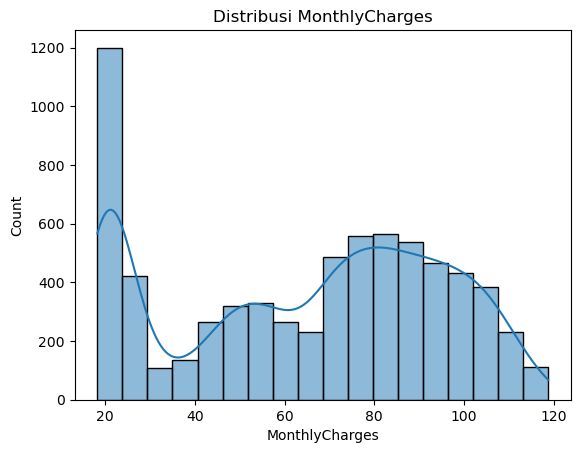

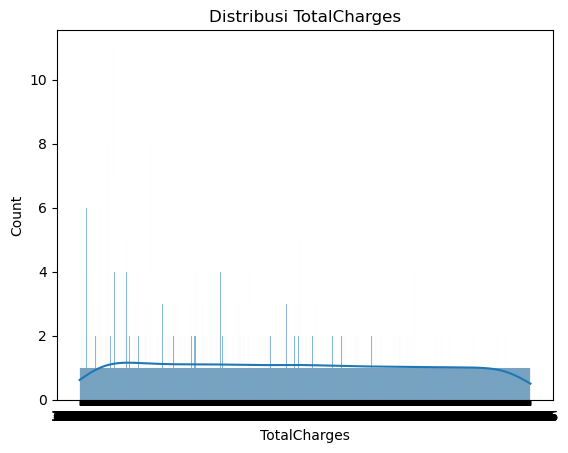

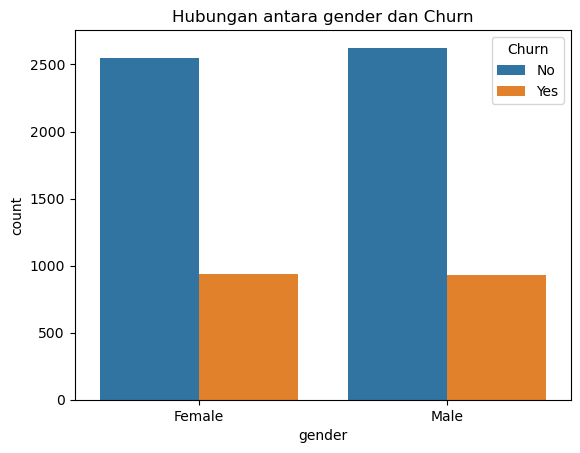

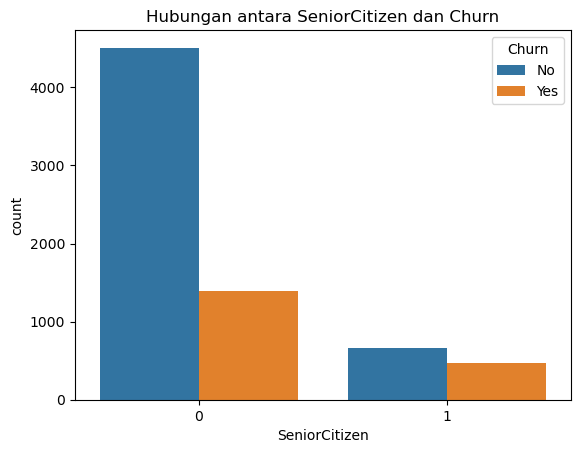

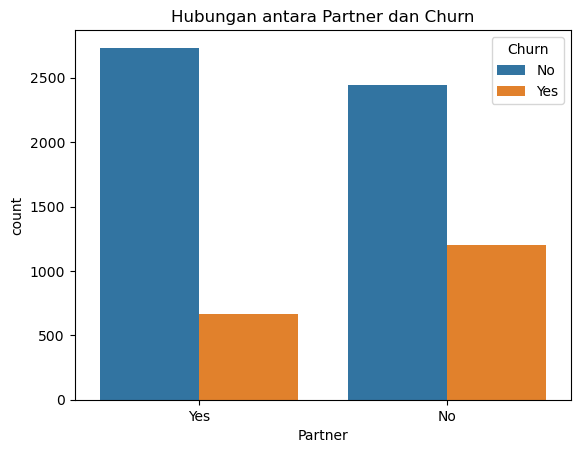

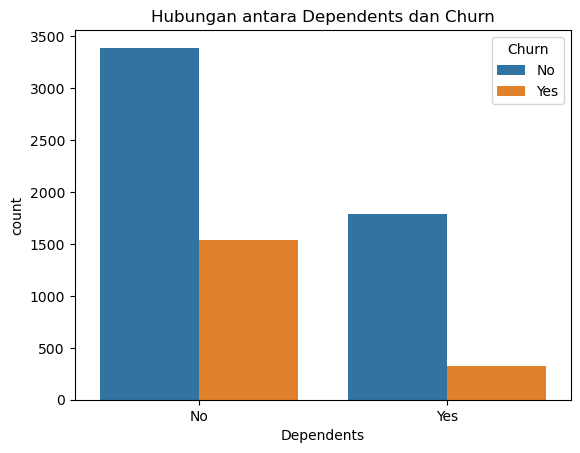

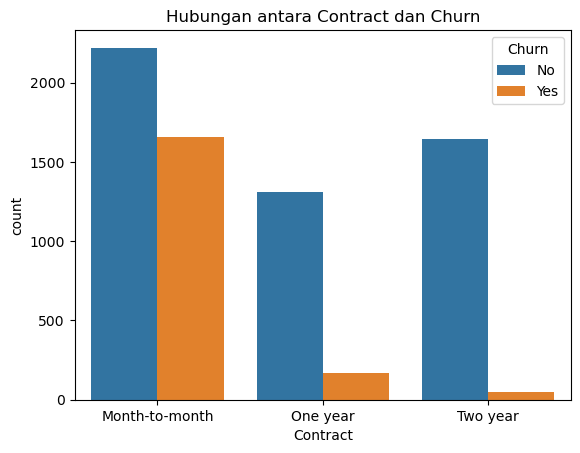

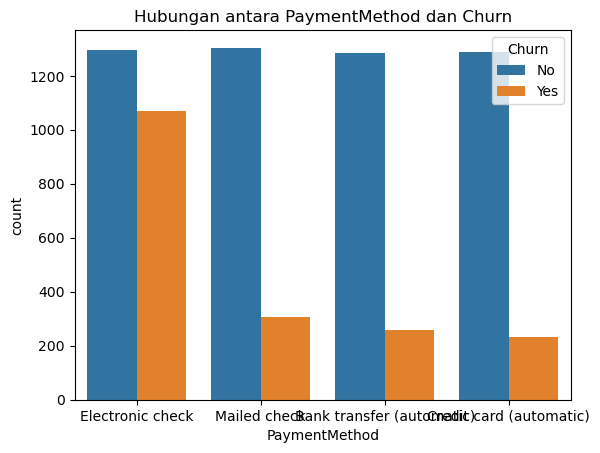

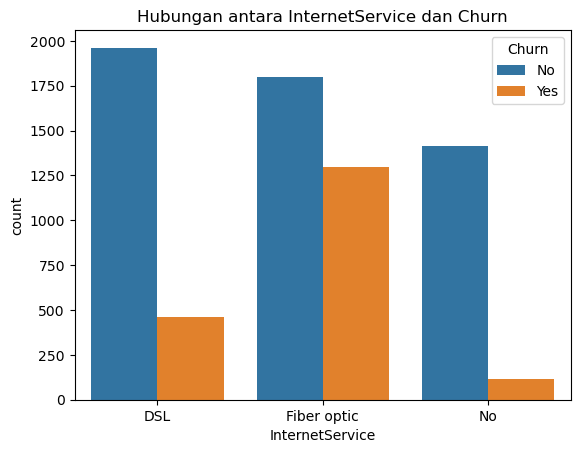

In [3]:
sns.histplot(telecom_customer['MonthlyCharges'], kde=True)
plt.title('Distribusi MonthlyCharges')
plt.show()

sns.histplot(telecom_customer['TotalCharges'], kde=True)
plt.title('Distribusi TotalCharges')
plt.show()

for col in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'PaymentMethod', 'InternetService']:
    sns.countplot(x=col, hue='Churn', data=telecom_customer)
    plt.title(f'Hubungan antara {col} dan Churn')
    plt.show()


In [4]:
### 1: Apa faktor-faktor utama yang memicu churn?
print("Analisis Churn berdasarkan Kontrak:")
churn_by_contract = telecom_customer.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
print(churn_by_contract)

print("\nAnalisis Churn berdasarkan Layanan Internet:")
churn_by_internet = telecom_customer.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()
print(churn_by_internet)

print("\nRata-rata MonthlyCharges untuk Churn vs Non-Churn:")
monthly_charges_churn = telecom_customer.groupby('Churn')['MonthlyCharges'].mean()
print(monthly_charges_churn)

print("Faktor-faktor seperti jenis kontrak, layanan internet, dan biaya bulanan memiliki korelasi kuat dengan churn. Pelanggan dengan kontrak bulanan dan layanan fiber optic cenderung lebih sering churn.")

Analisis Churn berdasarkan Kontrak:
Churn                 No       Yes
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887305  0.112695
Two year        0.971681  0.028319

Analisis Churn berdasarkan Layanan Internet:
Churn                  No       Yes
InternetService                    
DSL              0.810409  0.189591
Fiber optic      0.581072  0.418928
No               0.925950  0.074050

Rata-rata MonthlyCharges untuk Churn vs Non-Churn:
Churn
No     61.265124
Yes    74.441332
Name: MonthlyCharges, dtype: float64
Faktor-faktor seperti jenis kontrak, layanan internet, dan biaya bulanan memiliki korelasi kuat dengan churn. Pelanggan dengan kontrak bulanan dan layanan fiber optic cenderung lebih sering churn.



Churn Rate untuk pelanggan dengan kontrak bulanan dan fiber optic:
Churn Rate segmen berisiko tinggi: 54.61%
Segmen pelanggan dengan kombinasi kontrak bulanan dan layanan internet fiber optic adalah yang paling berisiko tinggi.


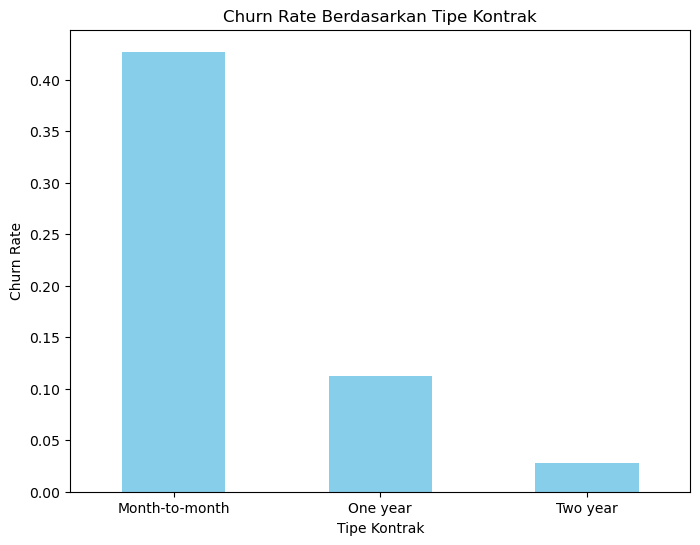

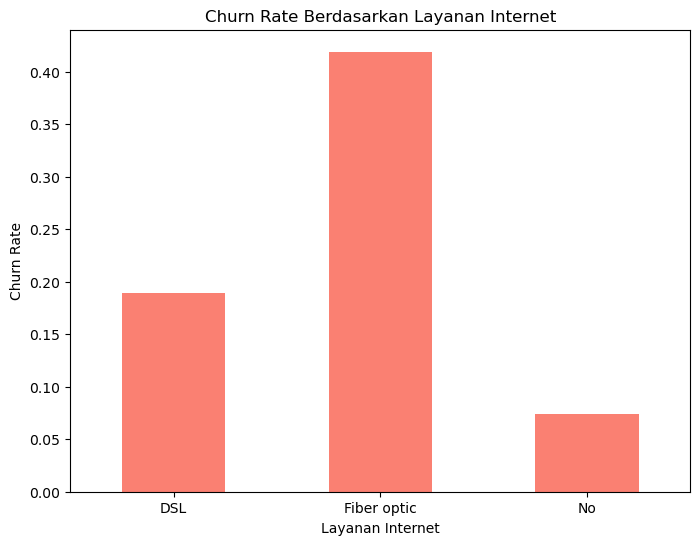

In [5]:
### 2 : Segmen pelanggan mana yang paling berisiko tinggi untuk churn?
print("\nChurn Rate untuk pelanggan dengan kontrak bulanan dan fiber optic:")
high_risk_segment = telecom_customer[(telecom_customer['Contract'] == 'Month-to-month') & (telecom_customer['InternetService'] == 'Fiber optic')]
churn_rate_high_risk = high_risk_segment['Churn'].value_counts(normalize=True).get('Yes', 0)
print(f"Churn Rate segmen berisiko tinggi: {churn_rate_high_risk:.2%}")

print('Segmen pelanggan dengan kombinasi kontrak bulanan dan layanan internet fiber optic adalah yang paling berisiko tinggi.')

plt.figure(figsize=(8, 6))
churn_by_contract = telecom_customer.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()
churn_by_contract['Yes'].plot(kind='bar', color='skyblue')
plt.title('Churn Rate Berdasarkan Tipe Kontrak')
plt.xlabel('Tipe Kontrak')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(8, 6))
churn_by_internet = telecom_customer.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack()
churn_by_internet['Yes'].plot(kind='bar', color='salmon')
plt.title('Churn Rate Berdasarkan Layanan Internet')
plt.xlabel('Layanan Internet')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

Persentase churn tanpa partner: 32.96%
Persentase churn tanpa tanggungan: 31.28%


C:\Users\PUTRI APRYANTI\AppData\Local\Temp\ipykernel_5320\2649387999.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segmen Pelanggan', y='Persentase Churn', data=df_plot, palette='magma')


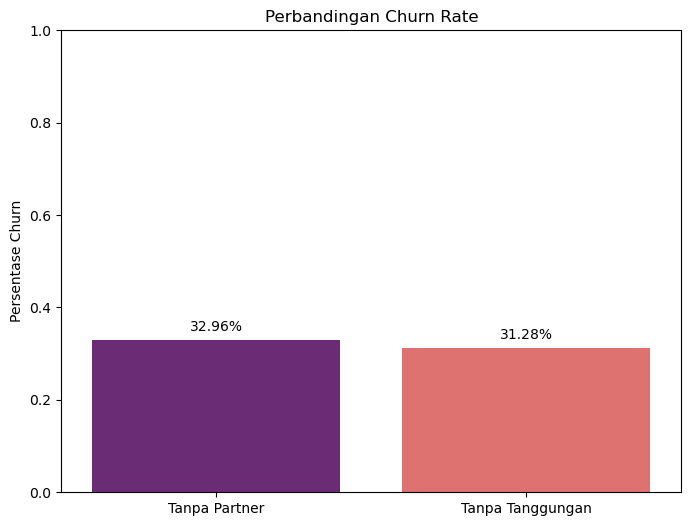

Pelanggan yang tidak memiliki ikatan keluarga (tanpa partner dan tanggungan) cenderung lebih mudah untuk churn.


In [6]:
### 3 : Bagaimana persebaran jumlah partner dan tanggungan (Dependents) di antara pelanggan yang churn?
churn_rate_no_partner = telecom_customer[(telecom_customer['Partner'] == 'No') & (telecom_customer['Churn'] == 'Yes')].shape[0] / telecom_customer[telecom_customer['Partner'] == 'No'].shape[0]
print(f"Persentase churn tanpa partner: {churn_rate_no_partner:.2%}")

churn_rate_no_dependents = telecom_customer[(telecom_customer['Dependents'] == 'No') & (telecom_customer['Churn'] == 'Yes')].shape[0] / telecom_customer[telecom_customer['Dependents'] == 'No'].shape[0]
print(f"Persentase churn tanpa tanggungan: {churn_rate_no_dependents:.2%}")

data_churn = {
    'Segmen Pelanggan': ['Tanpa Partner', 'Tanpa Tanggungan'],
    'Persentase Churn': [churn_rate_no_partner, churn_rate_no_dependents]
}
df_plot = pd.DataFrame(data_churn)

plt.figure(figsize=(8, 6))
sns.barplot(x='Segmen Pelanggan', y='Persentase Churn', data=df_plot, palette='magma')
plt.title('Perbandingan Churn Rate')
plt.ylabel('Persentase Churn')
plt.xlabel('')
plt.ylim(0, 1)
plt.text(x=0, y=churn_rate_no_partner + 0.02, s=f"{churn_rate_no_partner:.2%}", ha='center')
plt.text(x=1, y=churn_rate_no_dependents + 0.02, s=f"{churn_rate_no_dependents:.2%}", ha='center')
plt.show()

print('Pelanggan yang tidak memiliki ikatan keluarga (tanpa partner dan tanggungan) cenderung lebih mudah untuk churn.')


Churn Rate berdasarkan layanan TechSupport:
Churn                      No       Yes
TechSupport                            
No                   0.583645  0.416355
No internet service  0.925950  0.074050
Yes                  0.848337  0.151663


C:\Users\PUTRI APRYANTI\AppData\Local\Temp\ipykernel_5320\3543798455.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Layanan TechSupport', y='Churn Rate', data=df_plot, palette='viridis')


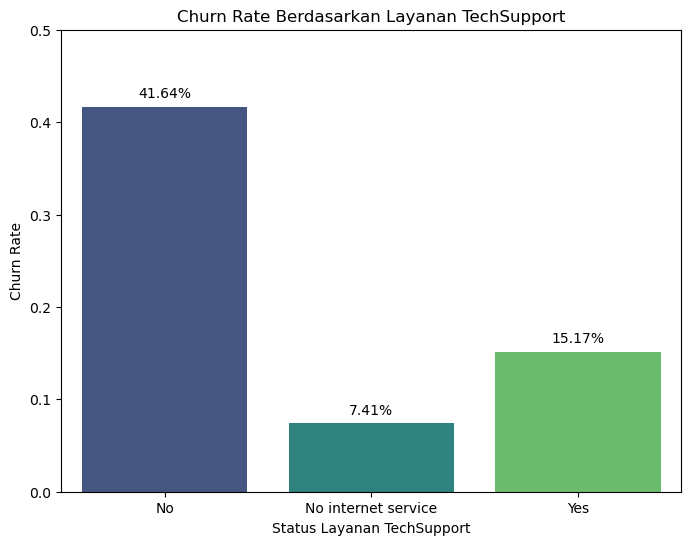

Pelanggan yang tidak berlangganan layanan pendukung seperti TechSupport cenderung lebih sering churn.


In [7]:
### 4 : Apakah ada korelasi antara layanan pelanggan dan churn?
print("\nChurn Rate berdasarkan layanan TechSupport:")
churn_by_techsupport = telecom_customer.groupby('TechSupport')['Churn'].value_counts(normalize=True).unstack()
print(churn_by_techsupport)


output = {
    'Churn': ['No', 'Yes'],
    'No': [0.583645, 0.416355],
    'No internet service': [0.925950, 0.074050],
    'Yes': [0.848337, 0.151663]
}
df_churn_techsupport = pd.DataFrame(output).set_index('Churn')

churn_rates = df_churn_techsupport.loc['Yes']

df_plot = pd.DataFrame({
    'Layanan TechSupport': churn_rates.index,
    'Churn Rate': churn_rates.values
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Layanan TechSupport', y='Churn Rate', data=df_plot, palette='viridis')
plt.title('Churn Rate Berdasarkan Layanan TechSupport')
plt.xlabel('Status Layanan TechSupport')
plt.ylabel('Churn Rate')
plt.ylim(0, 0.5)
plt.xticks(rotation=0)

for index, row in df_plot.iterrows():
    plt.text(index, row['Churn Rate'] + 0.01, f"{row['Churn Rate']:.2%}", color='black', ha="center")

plt.show()

print('Pelanggan yang tidak berlangganan layanan pendukung seperti TechSupport cenderung lebih sering churn.')

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64


C:\Users\PUTRI APRYANTI\AppData\Local\Temp\ipykernel_5320\3861936053.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Churn', y='Rata-rata Tenure', data=df_tenure, palette='coolwarm')


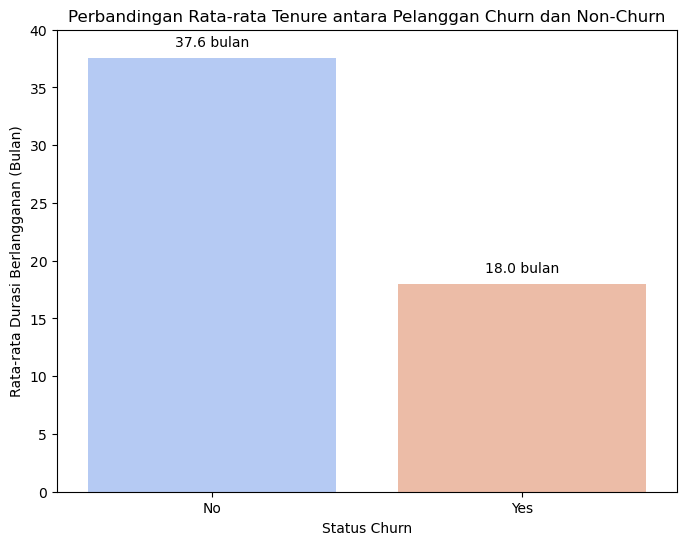

Rata-rata tenure untuk pelanggan yang Churn adalah 18 bulan, sedangkan untuk pelanggan yang tidak Churn adalah 37 bulan.


In [8]:
### 5 : Bagaimana perbandingan rata-rata durasi berlangganan (tenure) antara pelanggan yang churn dan tidak churn?
rata_rata_tenure = telecom_customer.groupby('Churn')['tenure'].mean()
print(rata_rata_tenure)

data_tenure = {
    'Churn': ['No', 'Yes'],
    'Rata-rata Tenure': [37.569965, 17.979133]
}
df_tenure = pd.DataFrame(data_tenure)

plt.figure(figsize=(8, 6))
sns.barplot(x='Churn', y='Rata-rata Tenure', data=df_tenure, palette='coolwarm')
plt.title('Perbandingan Rata-rata Tenure antara Pelanggan Churn dan Non-Churn')
plt.xlabel('Status Churn')
plt.ylabel('Rata-rata Durasi Berlangganan (Bulan)')
plt.ylim(0, 40)
plt.text(x=0, y=df_tenure['Rata-rata Tenure'][0] + 1, s=f"{df_tenure['Rata-rata Tenure'][0]:.1f} bulan", ha='center')
plt.text(x=1, y=df_tenure['Rata-rata Tenure'][1] + 1, s=f"{df_tenure['Rata-rata Tenure'][1]:.1f} bulan", ha='center')
plt.show()


print('Rata-rata tenure untuk pelanggan yang Churn adalah 18 bulan, sedangkan untuk pelanggan yang tidak Churn adalah 37 bulan.')

SeniorCitizen
0    0.236062
1    0.416813
Name: Yes, dtype: float64


C:\Users\PUTRI APRYANTI\AppData\Local\Temp\ipykernel_5320\50931145.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='SeniorCitizen', y='Churn Rate', data=df_seniority, palette='plasma')


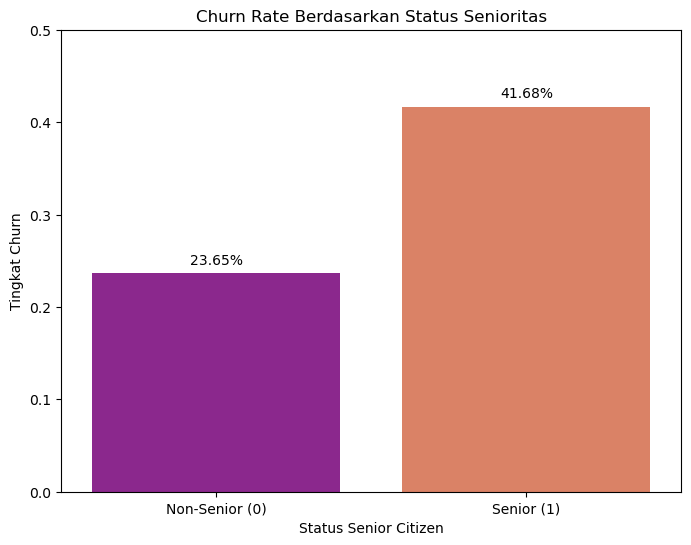

Tingkat churn untuk pelanggan senior (SeniorCitizen == 1) adalah 41.68%, lebih tinggi dari non-senior (SeniorCitizen == 0) yang hanya 23.65%.


In [9]:
### 6 : Apakah ada hubungan antara status senioritas (SeniorCitizen) dengan tingkat churn?
churn_rate_by_senior = telecom_customer.groupby('SeniorCitizen')['Churn'].value_counts(normalize=True).unstack().get('Yes', 0)
print(churn_rate_by_senior)

churn_rate_senior = 0.4168
churn_rate_non_senior = 0.2365

data_seniority = {
    'SeniorCitizen': ['Non-Senior (0)', 'Senior (1)'],
    'Churn Rate': [churn_rate_non_senior, churn_rate_senior]
}
df_seniority = pd.DataFrame(data_seniority)

plt.figure(figsize=(8, 6))
sns.barplot(x='SeniorCitizen', y='Churn Rate', data=df_seniority, palette='plasma')
plt.title('Churn Rate Berdasarkan Status Senioritas')
plt.xlabel('Status Senior Citizen')
plt.ylabel('Tingkat Churn')
plt.ylim(0, 0.5)
plt.text(x=0, y=churn_rate_non_senior + 0.01, s=f"{churn_rate_non_senior:.2%}", ha='center')
plt.text(x=1, y=churn_rate_senior + 0.01, s=f"{churn_rate_senior:.2%}", ha='center')
plt.show()

print('Tingkat churn untuk pelanggan senior (SeniorCitizen == 1) adalah 41.68%, lebih tinggi dari non-senior (SeniorCitizen == 0) yang hanya 23.65%.')

count    3096.000000
mean       91.500129
std        12.663039
min        67.750000
25%        80.550000
50%        91.675000
75%       101.150000
max       118.750000
Name: MonthlyCharges, dtype: float64


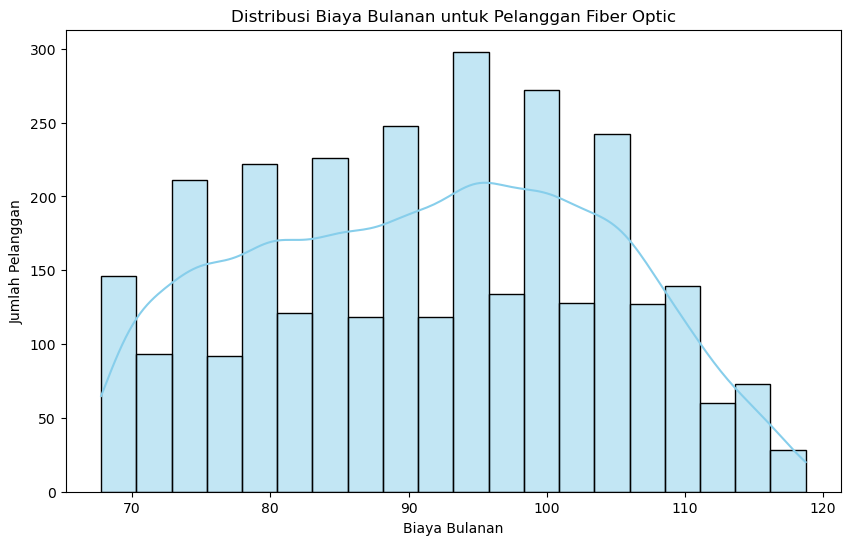

Pelanggan Fiber optic memiliki rata-rata biaya bulanan sebesar $91.50, dengan biaya terendah $67.75 dan tertinggi $118.75.


In [10]:
### 7 : Bagaimana distribusi biaya bulanan (MonthlyCharges) untuk pelanggan yang menggunakan layanan internet Fiber optic?
fiber_optic_charges = telecom_customer[telecom_customer['InternetService'] == 'Fiber optic']['MonthlyCharges'].describe()
print(fiber_optic_charges)

fiber_optic_charges = telecom_customer[telecom_customer['InternetService'] == 'Fiber optic']['MonthlyCharges']

plt.figure(figsize=(10, 6))
sns.histplot(fiber_optic_charges, bins=20, kde=True, color='skyblue')
plt.title('Distribusi Biaya Bulanan untuk Pelanggan Fiber Optic')
plt.xlabel('Biaya Bulanan')
plt.ylabel('Jumlah Pelanggan')
plt.show()

print('Pelanggan Fiber optic memiliki rata-rata biaya bulanan sebesar $91.50, dengan biaya terendah $67.75 dan tertinggi $118.75.')

Feature Engineering

Durasi berlangganan tidak selalu memiliki hubungan linier dengan churn. Dengan mengelompokkan tenure, model dapat menemukan pola churn yang unik di setiap kelompok.


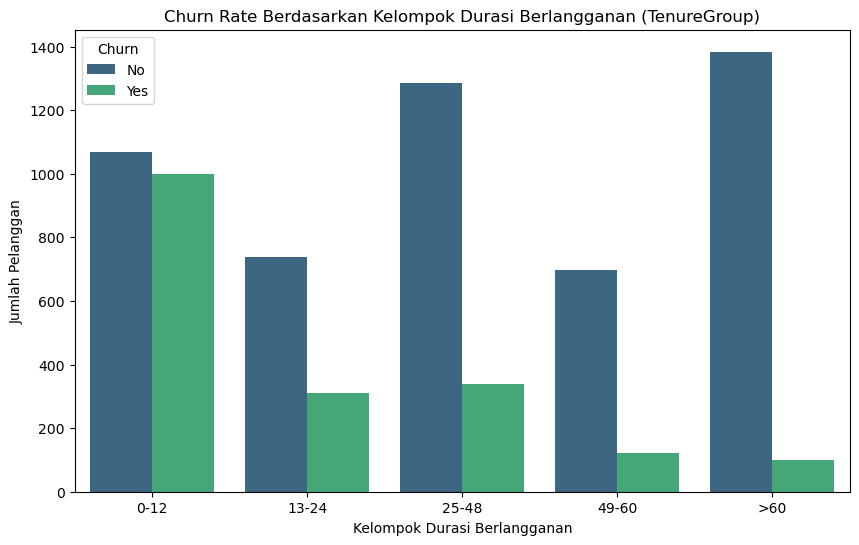

Fitur ini dapat mengidentifikasi pelanggan yang mungkin merasa membayar terlalu mahal (overpaying) relatif terhadap durasi berlangganan mereka. Rasio yang tinggi bisa menjadi indikasi ketidakpuasan, yang pada akhirnya dapat mengarah pada churn.


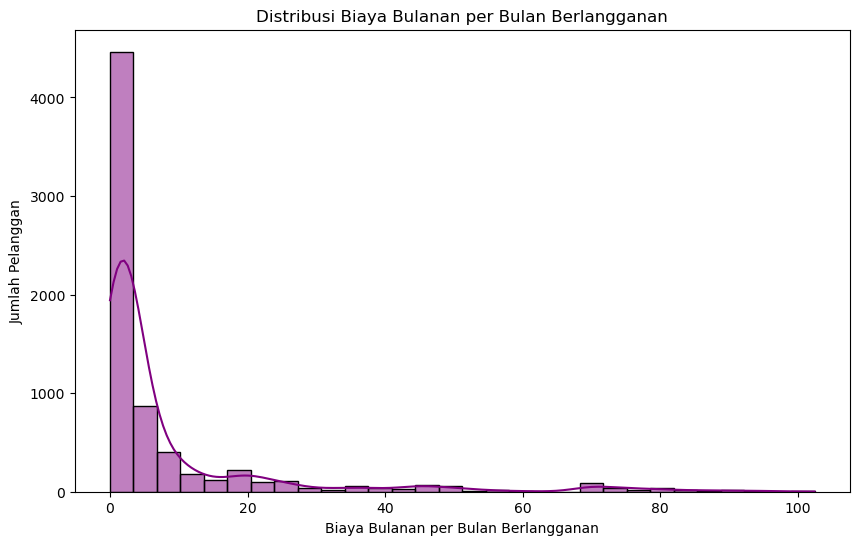

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... StreamingTV  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...          No   
4                No     Fiber optic             No  ...          No   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  \
0          

In [11]:
# Membuat grup berdasarkan 'Tenure'
bins = [0, 12, 24, 48, 60, np.inf]
labels = ['0-12', '13-24', '25-48', '49-60', '>60']
telecom_customer['TenureGroup'] = pd.cut(telecom_customer['tenure'], bins=bins, labels=labels, right=False)
print('Durasi berlangganan tidak selalu memiliki hubungan linier dengan churn. Dengan mengelompokkan tenure, model dapat menemukan pola churn yang unik di setiap kelompok.')

plt.figure(figsize=(10, 6))
sns.countplot(x='TenureGroup', hue='Churn', data=telecom_customer, palette='viridis')
plt.title('Churn Rate Berdasarkan Kelompok Durasi Berlangganan (TenureGroup)')
plt.xlabel('Kelompok Durasi Berlangganan')
plt.ylabel('Jumlah Pelanggan')
plt.show()

# Membuat fitur rasio biaya bulanan per lama berlangganan
# Menghindari pembagian dengan nol
telecom_customer['MonthlyChargesPerTenure'] = telecom_customer.apply(
    lambda row: row['MonthlyCharges'] / row['tenure'] if row['tenure'] > 0 else 0,
    axis=1
)
print('Fitur ini dapat mengidentifikasi pelanggan yang mungkin merasa membayar terlalu mahal (overpaying) relatif terhadap durasi berlangganan mereka. Rasio yang tinggi bisa menjadi indikasi ketidakpuasan, yang pada akhirnya dapat mengarah pada churn.')

plt.figure(figsize=(10, 6))
sns.histplot(telecom_customer['MonthlyChargesPerTenure'], bins=30, kde=True, color='purple')
plt.title('Distribusi Biaya Bulanan per Bulan Berlangganan')
plt.xlabel('Biaya Bulanan per Bulan Berlangganan')
plt.ylabel('Jumlah Pelanggan')
plt.show()

print(telecom_customer.head())

Modelling

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Fitting 3 folds for each of 8 candidates, totalling 24 fits
--- Evaluasi Model Logistic Regression ---
Recall: 0.7078
ROC-AUC: 0.8375
F1-Score: 0.6118

--- Evaluasi Model Random Forest (Tuned) ---
Recall: 0.7614
ROC-AUC: 0.8500
F1-Score: 0.6311


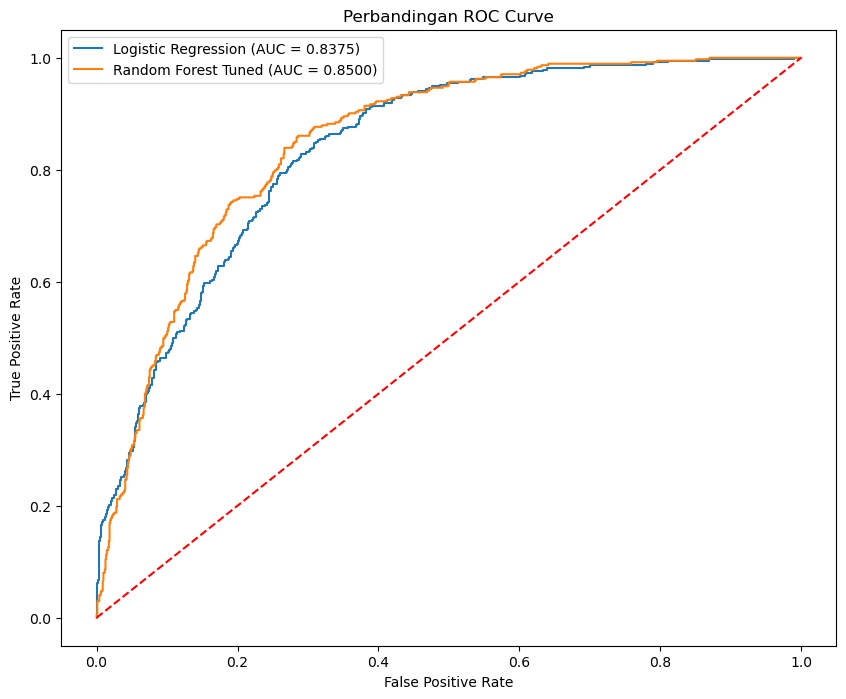


Optimal Threshold untuk F1-Score: 0.5395

--- Evaluasi Model Terbaik (dengan Optimal Threshold) ---
Recall: 0.7426
F1-Score: 0.6533


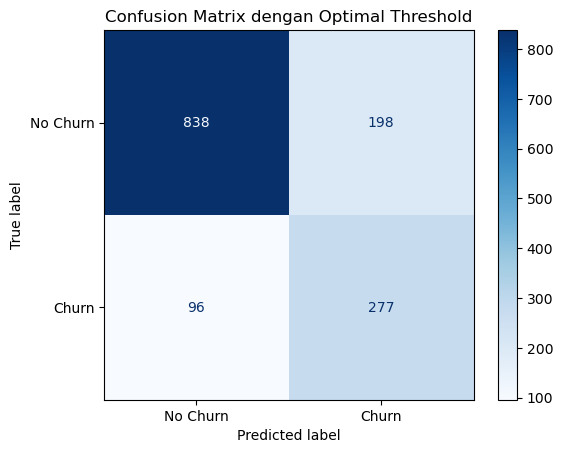

model Random Forest (Tuned) menjadi alat strategis yang efektif untuk mengidentifikasi pelanggan yang berisiko churn, memungkinkan perusahaan untuk menerapkan strategi retensi yang lebih terarah dan efisien.


In [12]:
categorical_features = telecom_customer.select_dtypes(include=['object', 'category']).columns
X = telecom_customer.drop('Churn', axis=1)
y = telecom_customer['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

for col in categorical_features:
    if col != 'Churn':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Terapkan SMOTE pada data training
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Model 1: Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_res, y_res)

# Model 2: Random Forest dengan Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='recall', # Fokus pada Recall
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_res, y_res)
best_model = grid_search.best_estimator_

# Evaluasi Model Logistic Regression
y_pred_lr = model_lr.predict(X_test)
y_pred_proba_lr = model_lr.predict_proba(X_test)[:, 1]

recall_lr = recall_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("--- Evaluasi Model Logistic Regression ---")
print(f"Recall: {recall_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}")

# Evaluasi Model Random Forest Terbaik (Tuned)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)[:, 1]

recall_tuned = recall_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print("\n--- Evaluasi Model Random Forest (Tuned) ---")
print(f"Recall: {recall_tuned:.4f}")
print(f"ROC-AUC: {roc_auc_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")

# Visualisasi Perbandingan ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Random Forest Tuned (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan ROC Curve')
plt.legend()
plt.show()

# Mencari threshold optimal untuk model Random Forest Tuned
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_tuned)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nOptimal Threshold untuk F1-Score: {optimal_threshold:.4f}")

y_pred_optimal = (y_pred_proba_tuned >= optimal_threshold).astype(int)

print("\n--- Evaluasi Model Terbaik (dengan Optimal Threshold) ---")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimal):.4f}")

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix dengan Optimal Threshold')
plt.show()

print('model Random Forest (Tuned) menjadi alat strategis yang efektif untuk mengidentifikasi pelanggan yang berisiko churn, memungkinkan perusahaan untuk menerapkan strategi retensi yang lebih terarah dan efisien.')


Analisis dan Rekomendasi Bisnis

In [13]:
print("\nAnalisis Model & Alasan Pemilihan Model Akhir")
print("Berdasarkan hasil evaluasi, model Random Forest yang sudah di-tuning dipilih sebagai model akhir karena menunjukkan performa yang lebih baik di semua metrik kunci dibandingkan dengan Logistic Regression.")
print("\nMetrik Perbandingan:")
print("1. Recall: Random Forest (0.7614) > Logistic Regression (0.7078)")
print("2. ROC-AUC: Random Forest (0.8500) > Logistic Regression (0.8375)")
print("3. F1-Score: Random Forest (0.6311) > Logistic Regression (0.6118)")
print("\nKesimpulan: Model Random Forest yang telah di-tuning adalah pilihan terbaik karena secara efektif menyeimbangkan kemampuan untuk mendeteksi pelanggan churn (Recall) dengan akurasi prediksi secara keseluruhan.")

print("\nRekomendasi Bisnis yang Tepat")
print("1. Program Retensi Bertarget: Gunakan model ini untuk mengidentifikasi pelanggan dengan probabilitas churn tertinggi. Tawarkan insentif seperti diskon, peningkatan layanan, atau dukungan khusus.")
print("2. Analisis Fitur: Model menunjukkan bahwa fitur seperti 'Contract', 'InternetService', dan 'Tenure' sangat berpengaruh. Dorong pelanggan 'Month-to-month' untuk beralih ke kontrak jangka panjang. Jika layanan internet (misalnya Fiber optic) adalah penyebabnya, fokus pada peningkatan kualitasnya.")
print("3. Optimalisasi Anggaran: Alokasikan anggaran dari kampanye retensi massal ke program retensi yang terfokus pada pelanggan yang benar-benar berisiko.")


Analisis Model & Alasan Pemilihan Model Akhir
Berdasarkan hasil evaluasi, model Random Forest yang sudah di-tuning dipilih sebagai model akhir karena menunjukkan performa yang lebih baik di semua metrik kunci dibandingkan dengan Logistic Regression.

Metrik Perbandingan:
1. Recall: Random Forest (0.7614) > Logistic Regression (0.7078)
2. ROC-AUC: Random Forest (0.8500) > Logistic Regression (0.8375)
3. F1-Score: Random Forest (0.6311) > Logistic Regression (0.6118)

Kesimpulan: Model Random Forest yang telah di-tuning adalah pilihan terbaik karena secara efektif menyeimbangkan kemampuan untuk mendeteksi pelanggan churn (Recall) dengan akurasi prediksi secara keseluruhan.

Rekomendasi Bisnis yang Tepat
1. Program Retensi Bertarget: Gunakan model ini untuk mengidentifikasi pelanggan dengan probabilitas churn tertinggi. Tawarkan insentif seperti diskon, peningkatan layanan, atau dukungan khusus.
2. Analisis Fitur: Model menunjukkan bahwa fitur seperti 'Contract', 'InternetService', dan '